In [1]:
using PyPlot, JLD, AnomalyDetection, EvalCurves
import PyPlot: plot
include("./plots.jl")

PyPlot.plot

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
X = AnomalyDetection.Float.(dataset.data)
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [3]:
# VAE settings
indim = size(X,1)
hiddendim = 10
latentdim = 2
nlayers = 2

# setup the VAE object
variant = :sigma
    # :unit - output has unit variance
    # :sigma - the variance of the output is estimated
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
# decoder architecture
(variant == :unit)? dsize = [latentdim; hiddendim; hiddendim; indim] :
    dsize = [latentdim; hiddendim; hiddendim; 2*indim]
lambda = 1 # KLD weight in loss function
threshold = 0 # classification threshold, is recomputed using setthreshold!()
contamination = size(Y[Y.==1],1)/size(Y, 1) # for automatic threshold computation
iterations = 2000
cbit = 500 # after this number of iteratiosn, callback is printed
verbfit = true
M = 1 # reconstruction error samples, for training 1 is OK
L = 50 # batchsize 
# set low for training but high for classification
activation = Flux.relu
layer = Flux.Dense
rdelta = Inf # reconstruction error threshold for training stopping
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.traindata
model = VAEmodel(esize, dsize, lambda, threshold, contamination, iterations, cbit, verbfit, 
    L, M=M, activation = activation, layer = layer, rdelta = rdelta, Beta = Beta, 
    tracked = tracked, variant = variant)

AnomalyDetection.VAEmodel(AnomalyDetection.VAE{Flux.Chain,AnomalyDetection.#sample_z,Flux.Chain,Val{:sigma}}(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), AnomalyDetection.sample_z, Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), Val{:sigma}()), 1, 0, 0.1262135922330097, 2000, 500, true, 50, 1, Inf32, 1.0f0, MVHistory{ValueHistories.History}, "likelihood")

In [4]:
# fit the model
AnomalyDetection.evalloss(model, nX)
@time AnomalyDetection.fit!(model, nX)
AnomalyDetection.evalloss(model, nX)
AnomalyDetection.setthreshold!(model, X)

loss: 0.41681606
likelihood: 0.15229172
KL: 0.237072

loss: -1.9748732
likelihood: -1.9835572
KL: 0.13505642

loss: -2.442126
likelihood: -2.905539
KL: 0.6859281

loss: -2.9059386
likelihood: -4.0722675
KL: 1.1146983

loss: -3.1559534
likelihood: -3.2763267
KL: 1.1065813

  7.418060 seconds (12.83 M allocations: 1.711 GiB, 5.44% gc time)
loss: -3.0637255
likelihood: -4.328886
KL: 1.1475037



-1.8306288f0

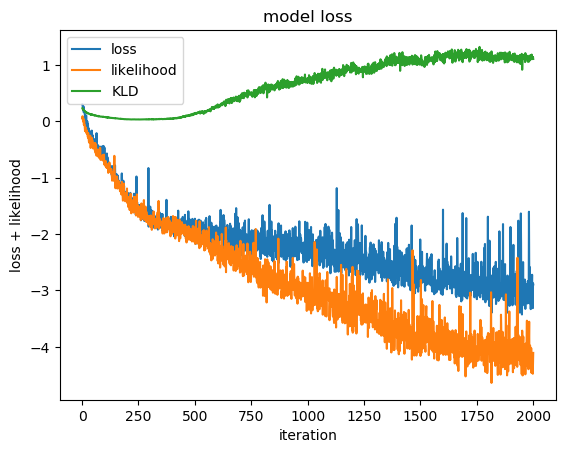

In [5]:
plot(model)
show()

How does the model reconstruct the normal data?

In [6]:
model(nX)

Tracked 4×90 Array{Float32,2}:
  0.764046   0.787531   0.793729  …   0.0476536   0.0436604   0.0449685
  0.790222   0.81377    0.844544      0.986063    0.988666    0.996007 
 -4.70214   -5.12737   -4.94211      -5.75467    -6.46655    -6.5472   
 -4.68831   -5.02785   -4.8951       -6.25677    -7.04578    -7.05586  

In [7]:
nX

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

What are the parameters of $q(z|x)$?

In [8]:
AnomalyDetection.muz(model, nX)

Tracked 2×90 Array{Float32,2}:
 -0.175262  -0.172865  -0.17647  …   0.333543   0.323869   0.310854
  1.00426    0.997397   1.01185     -1.42086   -1.37215   -1.32196 

In [9]:
AnomalyDetection.sigma2z(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.862436  0.862271  0.863008  0.864654  …  0.719194  0.723846  0.726012
 0.151788  0.150417  0.151479  0.149493     0.10642   0.104201  0.107287

What do the generated samples look like?

In [10]:
AnomalyDetection.sample_z(model, nX)

Tracked 2×90 Array{Float32,2}:
 -0.710935  -1.3549   1.12483  -0.0630848  …   1.26127  -0.199274   0.141743
  1.11246    0.89963  1.13179   1.29321       -1.45803  -1.40498   -1.34148 

In [11]:
# predict labels on testing data
model.M = 100 # for classification higher is better (more stable)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [12]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 90
  fp = 0
  fn = 0
precision: 1.0
f1score: 1.0
recall: 1.0
false positive rate: 0.0
equal error rate: 0.0

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 89
  fp = 1
  fn = 0
precision: 0.9285714285714286
f1score: 0.9629629629629629
recall: 1.0
false positive rate: 0.011111111111111112
equal error rate: 0.005555555555555556


In [13]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = linspace(xl[1], xl[2], 30)
y = linspace(yl[1], yl[2], 30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end

# also generate some samples
xgen = AnomalyDetection.generate(model, 3);

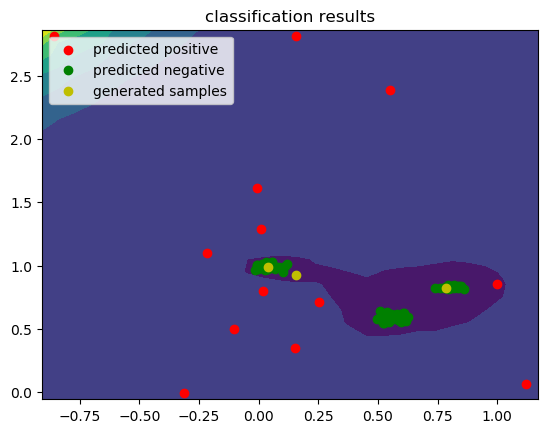

In [14]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
scatter(xgen[1,:], xgen[2, :], c = "y", 
    label = "generated samples")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

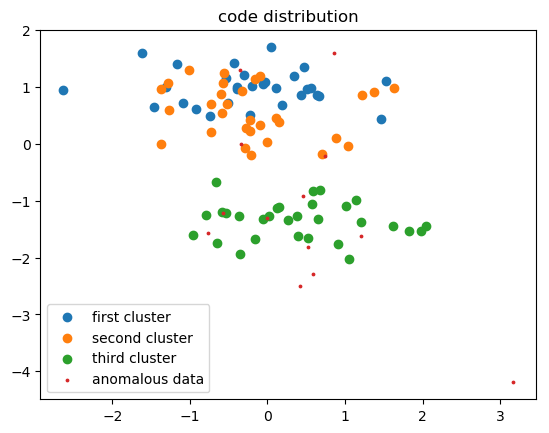

In [15]:
# what are the codes?
z1 = AnomalyDetection.getcode(model, X[:,1:30]).data
z2 = AnomalyDetection.getcode(model, X[:,31:60]).data
z3 = AnomalyDetection.getcode(model, X[:,61:90]).data
za = AnomalyDetection.getcode(model, X[:,91:end]).data

figure()
title("code distribution")
scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 3, label = "anomalous data")
legend()
show()

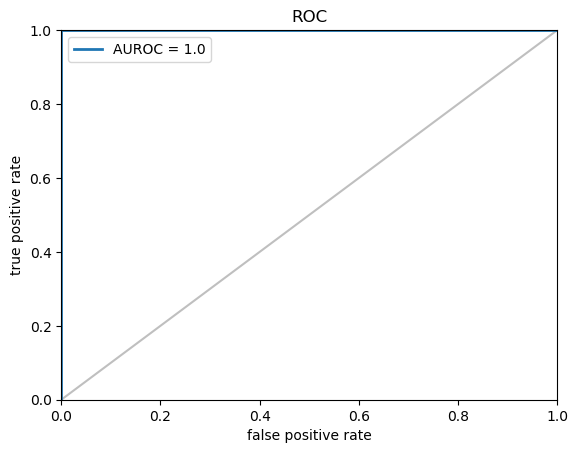

In [16]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()